In [1]:
import pandas as pd

In [2]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [3]:
#Download NLTK Data
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/nickponzi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nickponzi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
import pandas as pd

# Reading the Excel file
file_path = "/Users/nickponzi/Research/Top 4 NIH Data.xlsx"
data = pd.read_excel(file_path, engine='openpyxl')

# Display the first few rows of the dataframe
print(data.head())


  NIH Spending Categorization  \
0   No NIH Category available   
1   No NIH Category available   
2   No NIH Category available   
3   No NIH Category available   
4   No NIH Category available   

                                    Project Abstract  \
0  Idiopathic Pulmonary Fibrosis (IPF) inflicts a...   
1  Novel strategies are needed when standard appr...   
2  This  proposal  is  in  response  to  RFA-­DD-...   
3  PROJECT SUMMARY\nAccumulating evidence suggest...   
4  Project Summary\nGenomic research presents a u...   

                                       Project Title  \
0  Computational Methods for Systems Genetic Anal...   
1  WISP3 and Progressive Pseudorheumatoid Arthrop...   
2  COMP B-NATIONAL SB PATIENT REGISTRY AT THE BOS...   
3  Mapping and prediction of quantitative transcr...   
4          Advancing Equity in Rare Disease Genomics   

                             Public Health Relevance Administering IC  \
0  Idiopathic Pulmonary Fibrosis (IPF) inflicts a...  

In [5]:
#Missing Values
data = data.dropna()

In [6]:
#Preprocess the text data
def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return '  '.join(tokens)

data['Project Abstract'] = data['Project Abstract'].apply(preprocess_text)
data['Project Title'] = data['Project Title'].apply(preprocess_text)
data['Public Health Relevance'] = data['Public Health Relevance'].apply(preprocess_text)

In [7]:
print(data.head())

  NIH Spending Categorization  \
0   No NIH Category available   
1   No NIH Category available   
2   No NIH Category available   
3   No NIH Category available   
4   No NIH Category available   

                                    Project Abstract  \
0  idiopathic  pulmonary  fibrosis  ipf  inflicts...   
1  novel  strategies  needed  standard  approache...   
2  proposal  response  rfadd19001  research  appr...   
3  project  summary  accumulating  evidence  sugg...   
4  project  summary  genomic  research  presents ...   

                                       Project Title  \
0  computational  methods  systems  genetic  anal...   
1  wisp3  progressive  pseudorheumatoid  arthropa...   
2  comp  bnational  sb  patient  registry  boston...   
3  mapping  prediction  quantitative  transcripti...   
4         advancing  equity  rare  disease  genomics   

                             Public Health Relevance Administering IC  \
0  idiopathic  pulmonary  fibrosis  ipf  inflicts...  

In [8]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

# Download necessary NLTK data
nltk.download('vader_lexicon')

# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Function to calculate sentiment scores
def get_sentiment_scores(text):
    return sia.polarity_scores(text)['compound']

# Apply sentiment analysis to abstracts and titles
data['Abstract Sentiment'] = data['Project Abstract'].apply(get_sentiment_scores)
data['Title Sentiment'] = data['Project Title'].apply(get_sentiment_scores)

# Average the sentiment scores from abstract and title
data['Average Sentiment'] = data[['Abstract Sentiment', 'Title Sentiment']].mean(axis=1)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/nickponzi/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [9]:
# Classify grants based on average sentiment
data['Funding Outcome'] = data['Average Sentiment'].apply(lambda x: 0 if x < 0 else 1)


In [10]:
print(data.head)

<bound method NDFrame.head of                              NIH Spending Categorization  \
0                              No NIH Category available   
1                              No NIH Category available   
2                              No NIH Category available   
3                              No NIH Category available   
4                              No NIH Category available   
...                                                  ...   
18977  Aging; Cancer; Eye Disease and Disorders of Vi...   
18981       Neurodegenerative; Neurosciences; Prevention   
18986  Brain Disorders; Mental Retardation (Intellect...   
18989  Biotechnology; Brain Disorders; Gene Therapy; ...   
19075       Biotechnology; Immunization; Vaccine Related   

                                        Project Abstract  \
0      idiopathic  pulmonary  fibrosis  ipf  inflicts...   
1      novel  strategies  needed  standard  approache...   
2      proposal  response  rfadd19001  research  appr...   
3      pr

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Define the features and target variable
X = data.drop(columns=['Project Abstract', 'Project Title', 'Public Health Relevance', 'Funding Outcome'])
y = data['Funding Outcome']

# Identify and remove non-numeric columns
non_numeric_columns = X.select_dtypes(exclude=[float, int]).columns
X = X.drop(columns=non_numeric_columns)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict the funding outcome for the test set
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Combine the abstract and title text for TF-IDF vectorization
combined_text = data['Project Abstract'] + ' ' + data['Project Title']

# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=1000)
tfidf_matrix = vectorizer.fit_transform(combined_text)

# Add TF-IDF features to the dataframe
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
data = pd.concat([data.reset_index(drop=True), tfidf_df.reset_index(drop=True)], axis=1)

# Save the feature names
feature_names = vectorizer.get_feature_names_out()


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Define the features and target variable
X = data.drop(columns=['Project Abstract', 'Project Title', 'Public Health Relevance', 'Funding Outcome'])
y = data['Funding Outcome']

# Ensure all features are numeric
non_numeric_columns = X.select_dtypes(exclude=[float, int]).columns
X = X.drop(columns=non_numeric_columns)

# Save the final feature names after dropping non-numeric columns
final_feature_names = X.columns

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict the funding outcome for the test set
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.7048169556840077
              precision    recall  f1-score   support

           0       0.70      0.04      0.08       785
           1       0.70      0.99      0.82      1810

    accuracy                           0.70      2595
   macro avg       0.70      0.52      0.45      2595
weighted avg       0.70      0.70      0.60      2595



In [13]:
# Predict the funding outcome for the test set
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.7048169556840077
              precision    recall  f1-score   support

           0       0.70      0.04      0.08       785
           1       0.70      0.99      0.82      1810

    accuracy                           0.70      2595
   macro avg       0.70      0.52      0.45      2595
weighted avg       0.70      0.70      0.60      2595



In [20]:
def predict_funding_likelihood(abstract, title, model, vectorizer, final_feature_names):
    # Preprocess the input text
    abstract_cleaned = preprocess_text(abstract)
    title_cleaned = preprocess_text(title)
    combined_cleaned = abstract_cleaned + ' ' + title_cleaned
    
    # Extract features
    tfidf_features = vectorizer.transform([combined_cleaned]).toarray()
    
    # Create a DataFrame for the input features with the same columns as during training
    input_features = pd.DataFrame(tfidf_features, columns=vectorizer.get_feature_names_out())
    
    # Reindex the input features to ensure they match the training set
    input_features = input_features.reindex(columns=final_feature_names, fill_value=0)
    
    # Predict funding likelihood
    likelihood = model.predict(input_features)
    return likelihood[0]

# Example usage
abstract = "The aim of this research is to create a new app to help with Mental Health."
title = "Mental Health App"
print("Funding Likelihood:", predict_funding_likelihood(abstract, title, model, vectorizer, final_feature_names))


Funding Likelihood: 1


In [18]:
# Concatenate all the cleaned text from grant abstracts and titles
all_text = ' '.join(data['Project Abstract']) + ' ' + ' '.join(data['Project Title'])


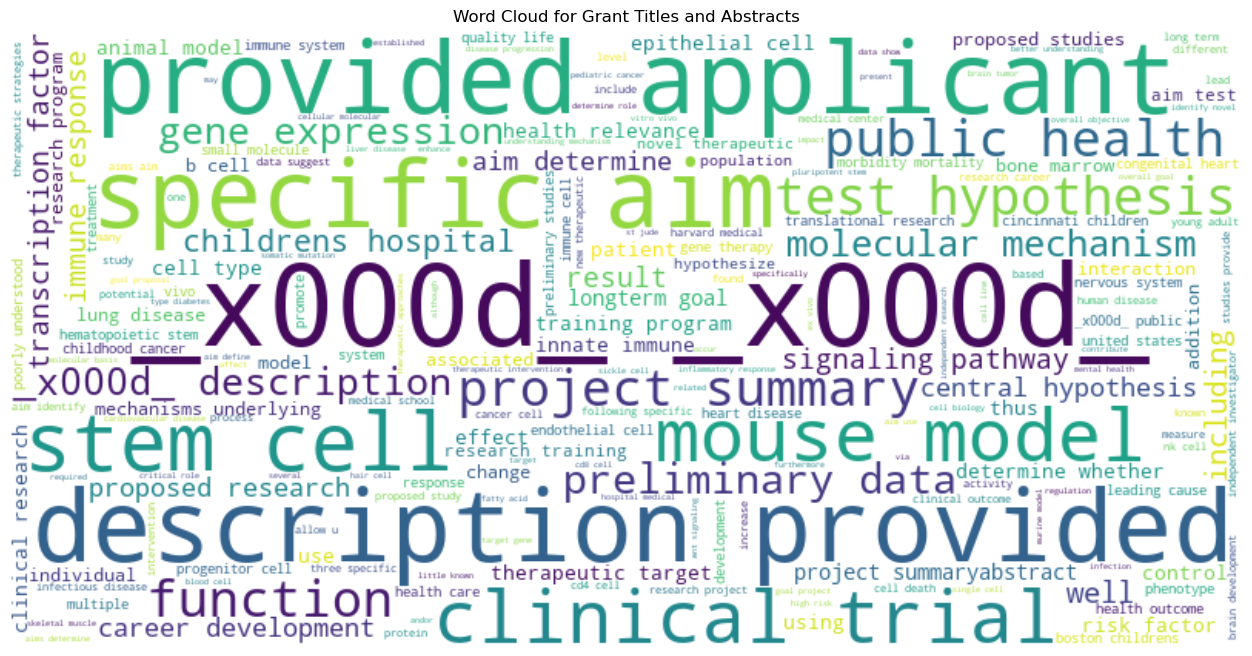

In [19]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Plot word cloud
plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Grant Titles and Abstracts')
plt.axis('off')
plt.show()
